## Chance de ataque cardíaco

## Sobre:

### Autor:
* Nome: João Gabriel Elvas Ribeiro
* Matricula: 190109599
* Github: JoaoGElvas

### Objetivo:
Atravez de uma serie de caracteristicas e exames de uma pessoa tentar prever a chance dela ter um ataque caridiaco, sendo dividido em '0' para menos chance e '1' para mais chance.

## Preparando o ambiente:

Inicialmente importamos as bibliotecas do fastai e definimos o caminho para o dataset que será utilizado.

In [3]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [ ]:
!pip install -Uqq fastai

In [5]:
from pathlib import Path
import os
os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
path = Path('../input/heart-attack-analysis-prediction-dataset/heart.csv')

In [6]:
df = pd.read_csv(path)
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [7]:
df.output.value_counts()

1    165
0    138
Name: output, dtype: int64

Aqui acima temos a contagem de '0' e '1' da nossa saída categorizada, além de trazer o nome dele e o tipo.

## Organizando o Dataset

Aqui vamos realizar a organização dos dados para serem utilizados no dataset. Neste caso iremos converte-los em variaves continuas

In [8]:
def proc_data(df):
    df['age'] = pd.Categorical(df.age)
    df['sex'] = pd.Categorical(df.sex)
    df['cp'] = pd.Categorical(df.cp) #dor no peito(1-4)
    df['exng'] = pd.Categorical(df.exng) #agina induzida por exercício
    df['restecg'] = pd.Categorical(df.restecg) #resultado do eletrocardiograma em repouso (0=normal 1=anomalia)
    df['chol'] = pd.Categorical(df.chol) #cholestoral pelo sensor BMI
    df['fbs'] = pd.Categorical(df.fbs) #açúcar no sangue em jejum>120mg/dl (0=falso 1=verdadeiro)
    df['output'] = pd.Categorical(df.output) # 0=menos chance ataque cardíaco 1=mais chanceataque cardíaco

proc_data(df)

In [9]:
#iremos utilizar apenas o "conts" por se tratar apenas de variáveis contínuas
conts=['age', 'sex', 'cp', 'exng','restecg', 'chol', 'fbs',]
dep="output"

In [10]:
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


 Podemos ver os valores armazenados no output

In [11]:
df.output.cat.codes.head()

0    1
1    1
2    1
3    1
4    1
dtype: int8

## Divisão Binária

Primeiramente antes de criar uma arvore de decição precisamos realizar a divisão binaria pois a arvore de decição é feita a partir da(s) mesma(s).

Vamos separar os dados em validaçõ e treinamento utilizando 'import train_test_split' que é importado do 'sklearn.model_selection'. Aqui definimos que dataframe de treinamento contém 80% dos dados originais, e o dataframe de validação contém 20% dos dados originais.

In [12]:
from sklearn.model_selection import train_test_split

trn_df,val_df = train_test_split(df, test_size=0.2)

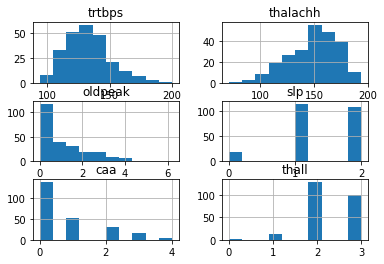

In [13]:
trn_df.hist();

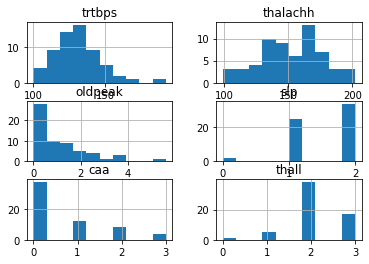

In [14]:
val_df.hist();

Podemos perceber nos histogramas (gráfico usado para representar a distribuição de frequência) acima que há uma boa divisão entre os dados (validação e treinamento), pela comparação dos dados, porém os histogramas da pressão arterial em repouso (trtbps) e da frequência cardíaca máxima alcançada (thalachh) são os que tem a maior divergencia entre os dois.

A seguir vamos separar em duas variáveis 'x' e 'y' as colunas do nosso dataframe.

'X' Vai receber as colunas continuas (definidas anterirmente no "counts").
'Y' Vai receber a coluna de classificação (0 ou 1).

Utilizamos o método copy() para criar uma cópia independente dos dados, garantindo que quaisquer modificações em trn_x ou trn_y não afetem o DataFrame original.

Essa separação foi feita visando facilitar o treinamento de modelos de aprendizado de máquina, pois assim 'x' e 'y' são tratados de forma separada durante o processo de treinamento.

In [15]:
def xs_y(df):
    xs = df[conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [16]:
trn_xs

,age,sex,cp,exng,restecg,chol,fbs
236,58,1,0,0,0,300,0
204,62,0,0,0,0,164,0
136,60,0,2,0,1,178,1
293,67,1,2,0,0,212,0
270,46,1,0,0,0,249,0
...,...,...,...,...,...,...,...
140,51,0,2,0,0,295,0
105,68,0,2,0,0,211,0
246,56,0,0,1,0,409,0
115,37,0,2,0,1,215,0


In [17]:
trn_y

236    0
204    0
136    1
293    0
270    0
      ..
140    1
105    1
246    0
115    1
120    1
Name: output, Length: 242, dtype: category
Categories (2, int64): [0, 1]

Podemos ver acima o que contém nas variáveis trn_x e trn_y.


## Criando a arvore de decisão

### Arvore 1

A seguir vamos criar a arvore de decisão utilizando o parâmetro *max_leaf_nodes* que é definido como 4, o que significa que a árvore de decisão terá no máximo 4 nós/folhas. 

In [18]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

Logo apos vamos imprimir a arvore, com o tamanho 10.
Neste caso *size* e *ratio* controlam o tamanho e a proporção da imagem da árvore, respectivamente. *Precision* define o número de casas decimais a serem exibidas nos nós da árvore. *Kwargs* permite passar outros argumentos opcionais.

In [19]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

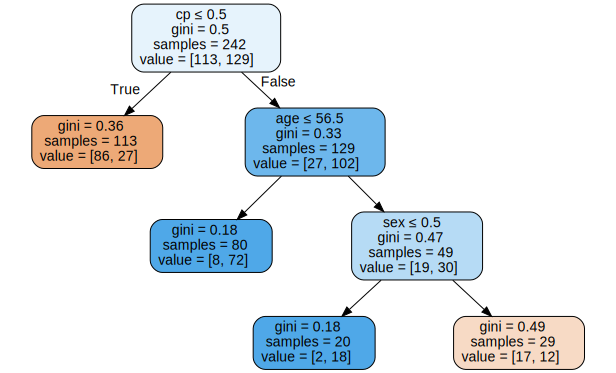

In [20]:
draw_tree(m, trn_xs, size=10)

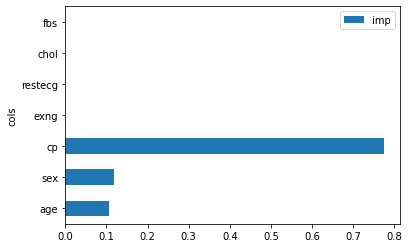

In [21]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

Utilizamos o grafico acima para verificar a importancia de cada coluna no resultado do modelo.
Apartir do mesmo é possivel notar que muitos dados não foram utilizados nesse árvore, e que os mais usados foram o dor no peito (cp), agina induzida por exercício (exng) e sexo da pessoa.

### Arvore 2

A seguir vamos refazer os mesmos codigos acima para gerar uma arvore porém iremos definir o maximo de nós/folhas para 9.

In [38]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=9).fit(trn_xs, trn_y);

In [39]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

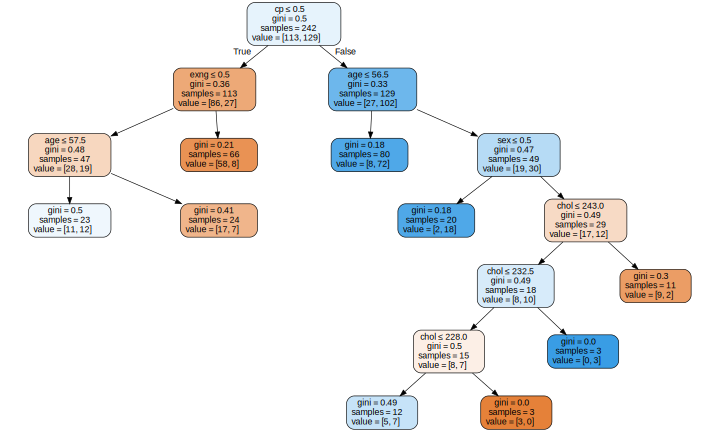

In [40]:
draw_tree(m, trn_xs, size=10)

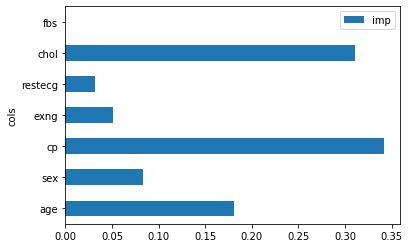

In [25]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

Podemos perceber a utilização de colunas a mais nessa arvore, além de uma maior complexidade.
Podemos perceber tambem que ela não ficou muito balanciada.

## Testando o Modelo


Aqui realizaremos o teste no modelo.

In [43]:
tst_x = trn_df[conts].copy()
tst_y = trn_df['output'].copy()

A seguir em *preds* vamos ter as previsões do modelo para o conjunto de dados de teste.
E em seguida o resultado vai ser a comparação das previsões feitas pelo modelo *preds* com os rótulos do conjunto de dados de teste tst_y.

In [58]:
preds = m.predict(tst_x)
result = preds == tst_y

In [59]:
tst_y

236    0
204    0
136    1
293    0
270    0
      ..
140    1
105    1
246    0
115    1
120    1
Name: output, Length: 242, dtype: category
Categories (2, int64): [0, 1]

In [62]:
qtd_error = result.value_counts()[False]
qtd_total = len(result)
((qtd_error*100)/qtd_total)

17.768595041322314

Tivemos um errdo de 17.76% nesse modelo.


## Conclusão

O modelo teve um bom desempenho porem tem uma taxde erro considerada.

## Deploy do Modelo

Link para a utilização do [modelo](https://huggingface.co/spaces/JoaoElvas/HeartAtack)

In [ ]:
import joblib

joblib.dump(m, 'tree_model.pkl')